In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

plt.rcParams["figure.figsize"] = (10,8)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

### Problem 1.
#### 1)

In [7]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

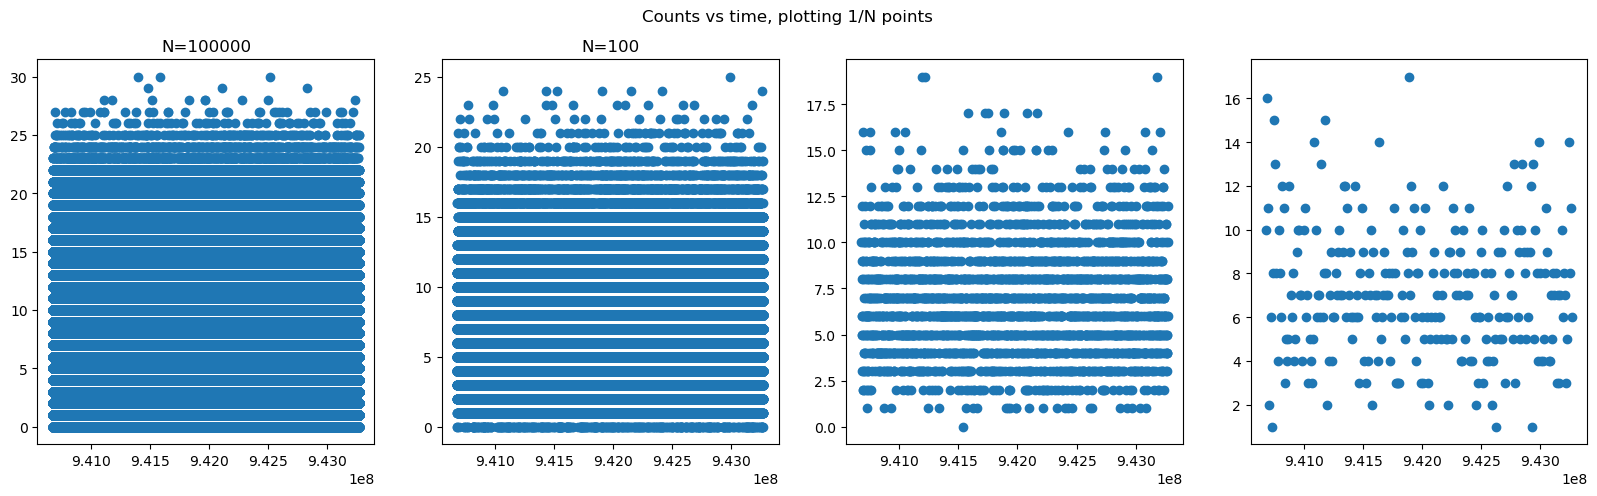

In [8]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].scatter(data[0,:], data[3,:])
ax[0].set_title('N=1')
ax[1].scatter(data[0,::100], data[3,::100])
ax[1].set_title('N=100')
ax[2].scatter(data[0,::10000], data[3,::10000])
ax[0].set_title('N=10000')
ax[3].scatter(data[0,::100000], data[3,::100000])
ax[0].set_title('N=100000')
plt.suptitle('Counts vs time, plotting 1/N points')
plt.show()

Plotting all of the points fills the plot and makes it impossible to see any features. When plotting only some of the data points, it does look like there is some kind of periodic variability in the background. There doesn't appear to be any data contamination, as there aren't any counts beyond ~30, so there aren't any extreme outliers.

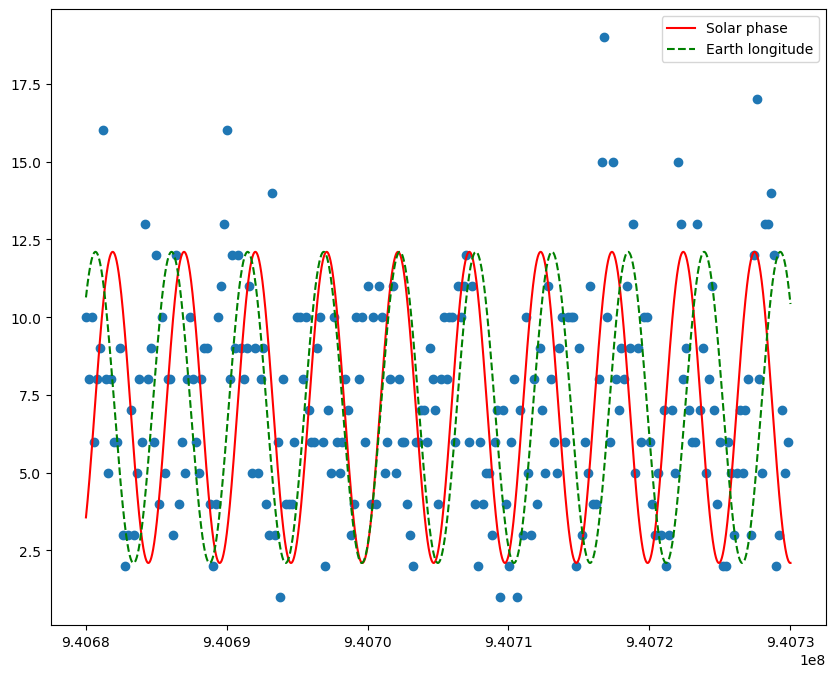

In [9]:
plt.scatter(data[0,:500000:2000], data[3,:500000:2000])
plt.plot(data[0,:500000], np.sin(data[1,:500000]*2*np.pi/360)*5 + np.mean(data[3,:]), c='r', label='Solar phase')
plt.plot(data[0,:500000], np.sin(data[2,:500000]*2*np.pi/360)*5 + np.mean(data[3,:]), c='g', linestyle='--', label='Earth longitude')
plt.legend()
plt.show()

The solar phase and Earth longitude both appear to have a regular period, but they don't have the same period and phase. It's hard to tell from this plot which, if either, is the contributing factor for the variability of the distribution.

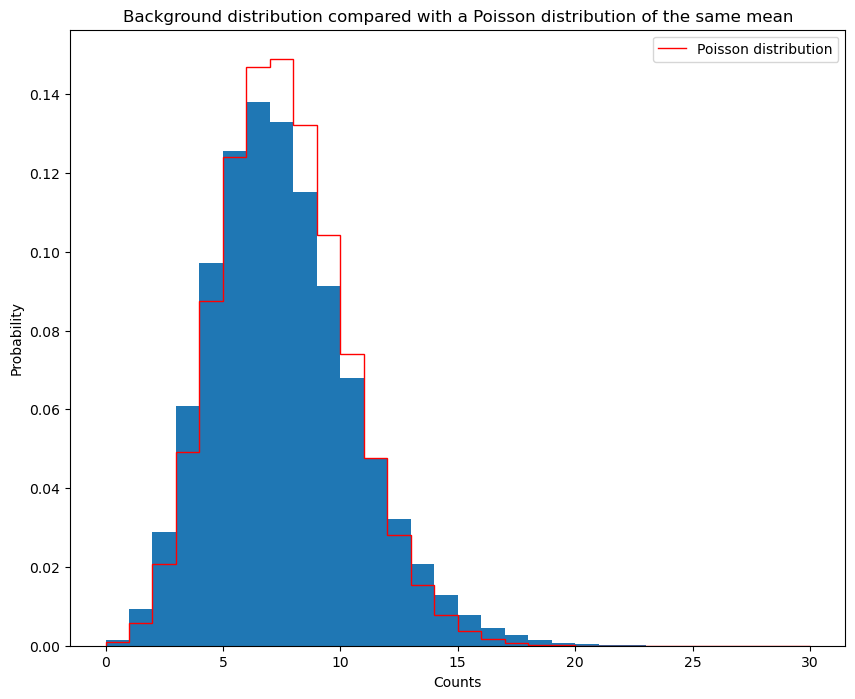

In [10]:
h, bins, patches = plt.hist(data[3,:], density=True, bins=30)
mu = np.mean(data[3,:])
x = np.arange(0,30)
plt.stairs(stats.poisson.pmf(x,mu), color='r', label='Poisson distribution')
plt.title('Background distribution compared with a Poisson distribution of the same mean')
plt.ylabel('Probability')
plt.xlabel('Counts')
plt.legend()
plt.show()


The distribution is close to, but not quite, a Poisson distribution with a mean equal to the mean of the counts.

#### 2)

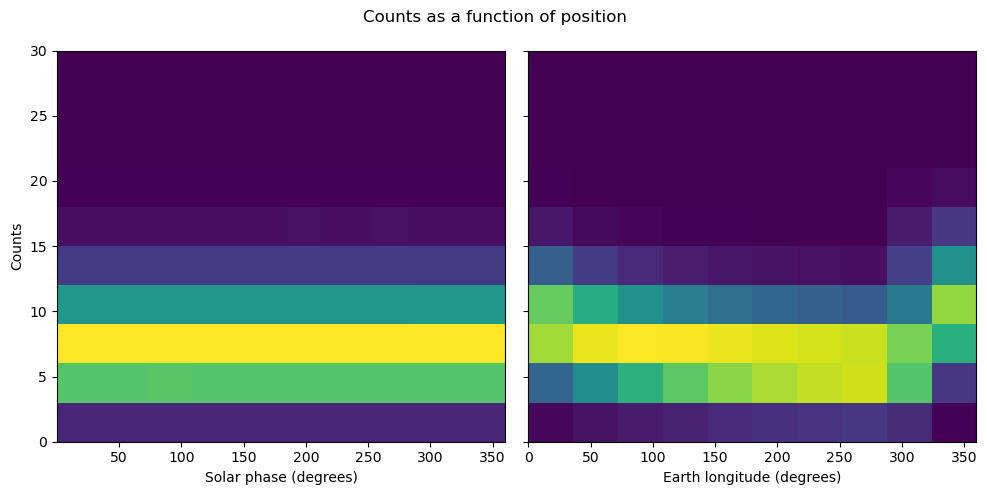

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].hist2d(data[1,:], data[3,:])
ax[1].hist2d(data[2,:], data[3,:])
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Solar phase (degrees)')
ax[1].set_xlabel('Earth longitude (degrees)')
plt.suptitle('Counts as a function of position')
plt.tight_layout()
plt.show()

Here, it's much more clear how the background distribution changes with time. Solar phase does not seem to have any impact on counts, but Earth longitude does. As the background changes with the angle, this means the mean of the Poisson distribution changes with the angle as well.

#### 3)

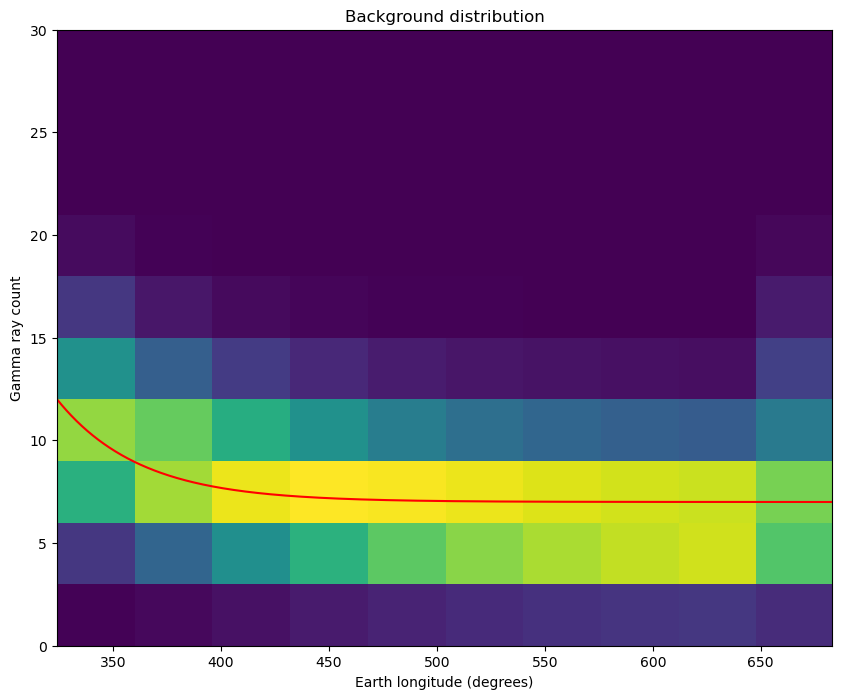

In [19]:
x0 = 324
A = 5
k = 1.5
C = 7
r = 2*np.pi/360 # convert degrees to radians

x = np.linspace(x0, 360+x0, 1000)

plt.hist2d(data[2,:], data[3,:])
plt.hist2d(data[2,:]+360, data[3,:])
plt.xlim(324,683)
plt.plot(x, A*np.exp(-k*r*(x-x0))+C,c='r', label='Exponential function')
plt.title('Background distribution')
plt.xlabel('Earth longitude (degrees)')
plt.ylabel('Gamma ray count')
plt.show()


After shifting the phase of the counts vs longitude plot, we can see that a function that roughly matches the mean of the distribution as a function of angle is an exponential function in the form $\mu(\theta) = Ae^{-k\theta}+C$. The values $A=5$, $k=1.5$ and $C=7$ give a good approximation of the distribution of the background as a function of Earth longitude.

#### 4)

To see how the 5 sigma value changes over time, instead of looking at it directly as a function of time I will plot it as a function of Earth longitude, using a function that takes the probability corresponding to 5 sigma, then using an inverse survival function to find the gamma ray count for a Poisson distribution with the value of $\mu$ at that Earth longitude.

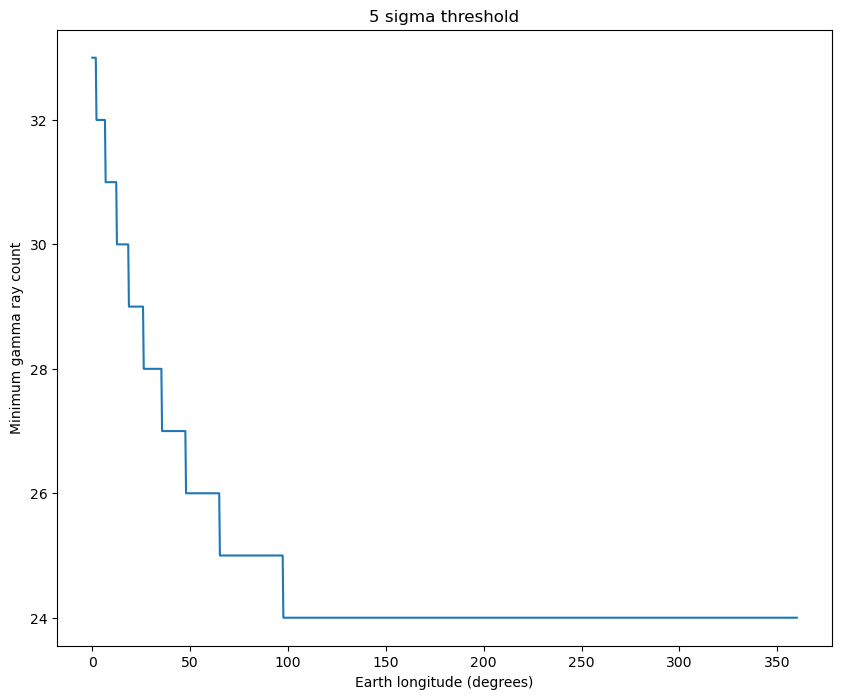

In [156]:
x = np.linspace(0,360,1000)
p = stats.norm.sf(5)
def sigma(theta, p):
    mu = 5 * np.exp(-1.5*theta*2*np.pi/360) + C
    return stats.poisson.isf(p, mu)
plt.plot(x, sigma(x, p))
plt.title('5 sigma threshold')
plt.ylabel('Minimum gamma ray count')
plt.xlabel('Earth longitude (degrees)')
plt.show()

### Problem 2.

For this problem, I will be looking for the faintest stars.

#### 1)

In [13]:
stars_file = h5py.File('images.h5', 'r')
stars_file.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [14]:
stars = np.array(stars_file.get('imagestack'))

In [51]:
stars[0]

array([[-0.50492093,  0.24975188, -0.50405229, ..., -0.06210173,
         1.19841096, -0.5545422 ],
       [ 0.31347367,  0.51688201, -0.31138079, ...,  0.33398174,
         0.55016787, -0.34058838],
       [ 0.77349547,  0.67896143, -0.6113714 , ...,  0.27080669,
        -0.68046639,  0.18246055],
       ...,
       [-0.04589657,  0.97223818, -0.71404873, ...,  0.65576281,
        -0.54599168,  0.21560286],
       [-0.11759723,  0.62046056,  0.09021457, ..., -0.34188113,
         0.54884142, -0.08468977],
       [ 0.73567588,  0.03022051, -0.24726976, ..., -0.23116598,
        -0.26072648, -0.52367269]])

The pixel values for this data aren't integer counts, so we should expect the distribution to be continuous rather than discrete.

In [54]:
np.min(stars)

-2.709336827866645

#### 2) 
First, I'll a plot the data to inspect it.

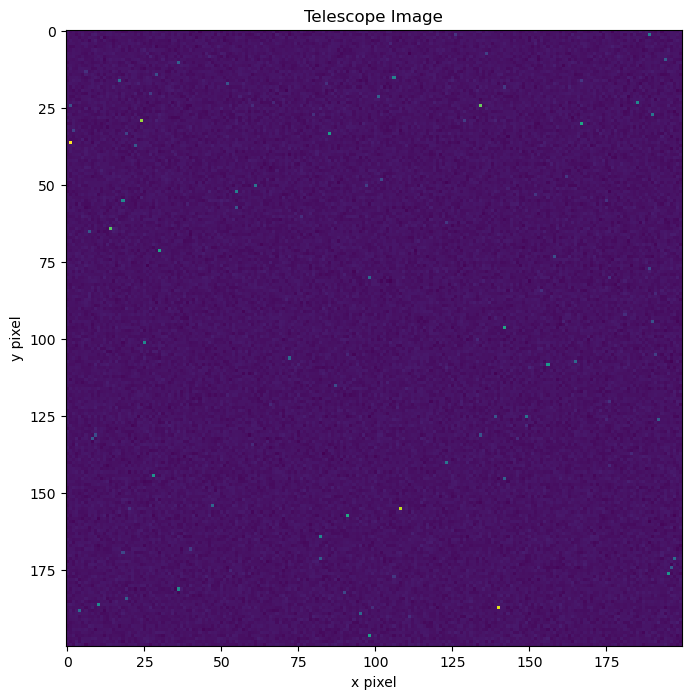

In [66]:
plt.imshow(stars[:,:,6])
plt.title('Telescope Image')
plt.ylabel('y pixel')
plt.xlabel('x pixel')
plt.show()

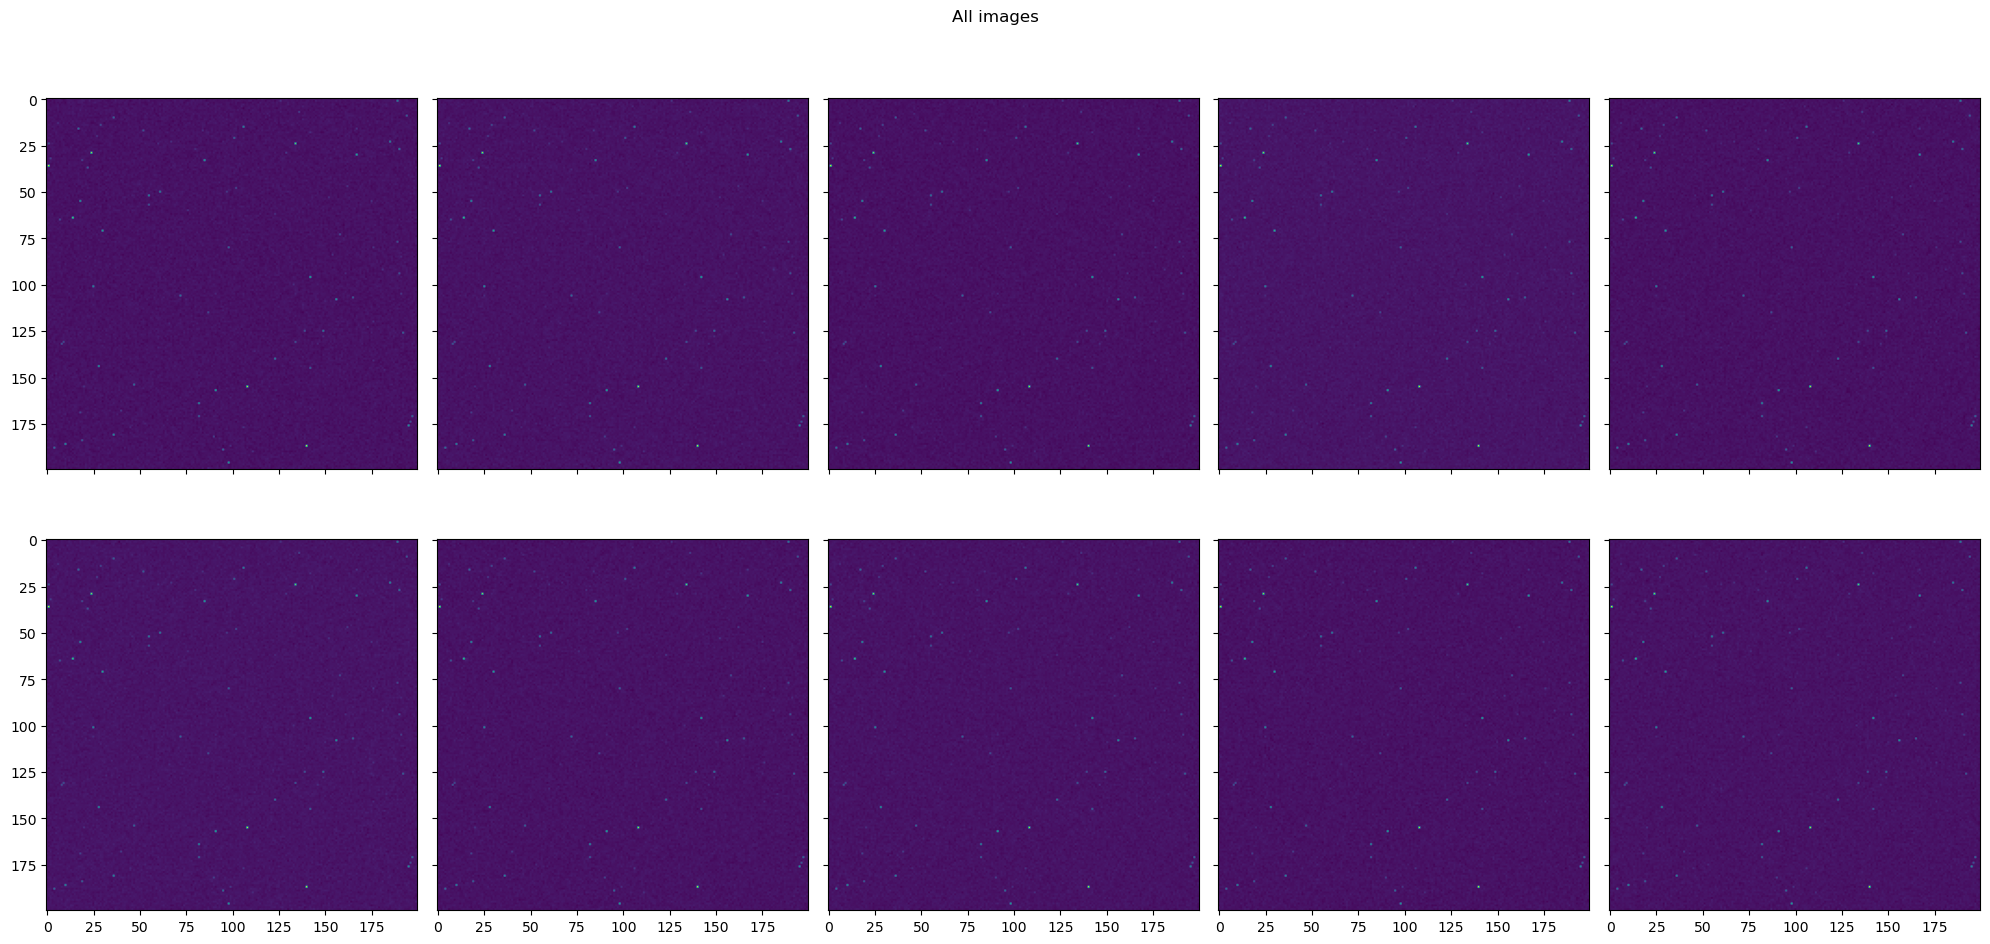

In [67]:
fig, ax = plt.subplots(2,5, figsize=(20,10), sharex=True, sharey=True)
for i in range(0,5):
    ax[0,i].imshow(stars[:,:,i])
for i in range(0,5):
    ax[1,i].imshow(stars[:,:,i+5])
plt.suptitle('All images')
plt.tight_layout()

There doesn't appear to be any data contamination, like obvious cosmic rays or other artifacts.

To see if there is time dependence, I'll look along one axis and see if it changes. We should expect to see a distribution that is the background, with some additional counts in the higher values corresponding to the stars. If the background doesn't change in time, then the central distribution should stay roughly the same.

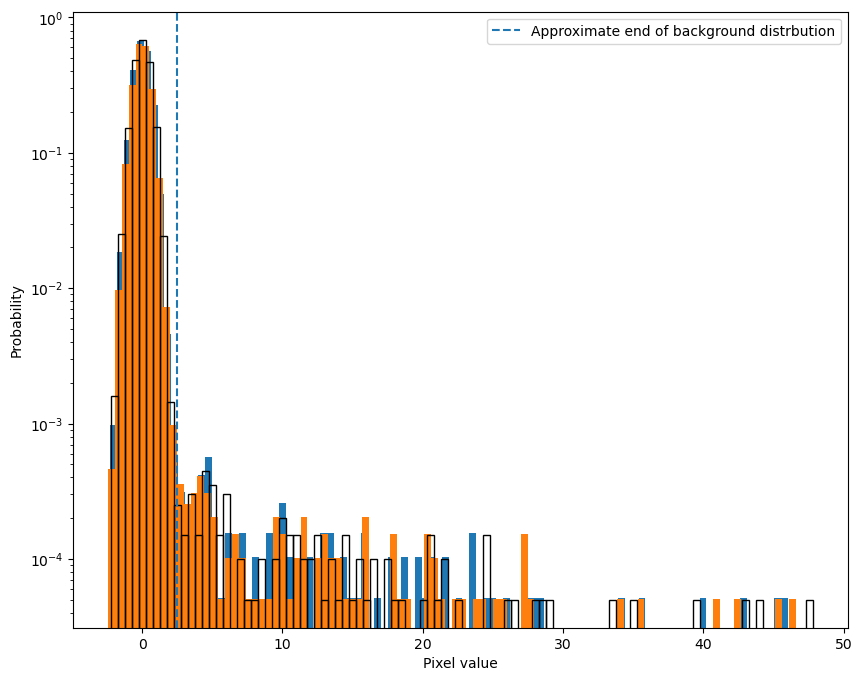

In [64]:
x = np.arange(0,200)
one_d = []

for i in range(0,10):
    image = []
    for j in range(0,200):
        for k in range(0,200):
            image.append(stars[j,k,i])
    one_d.append(image)
    
plt.hist(one_d[0], bins=100, density=True)
plt.hist(one_d[1], bins=100, density=True)
plt.hist(one_d[2], bins=100, fill=False, density=True)
plt.axvline(2.5, linestyle='--', label='Approximate end of background distrbution')
plt.yscale('log')
plt.ylabel('Probability')
plt.xlabel('Pixel value')
plt.legend()
plt.show()

We can see here that just about every part of the distribution is changing with time, though the background doesn't change a very large amount. To find the final background pdf(), I will exclude higher values to remove the stars, then I will convolve and average the backgrounds. From above, it appears that counts above about 2 should be excluded from the background distribution.

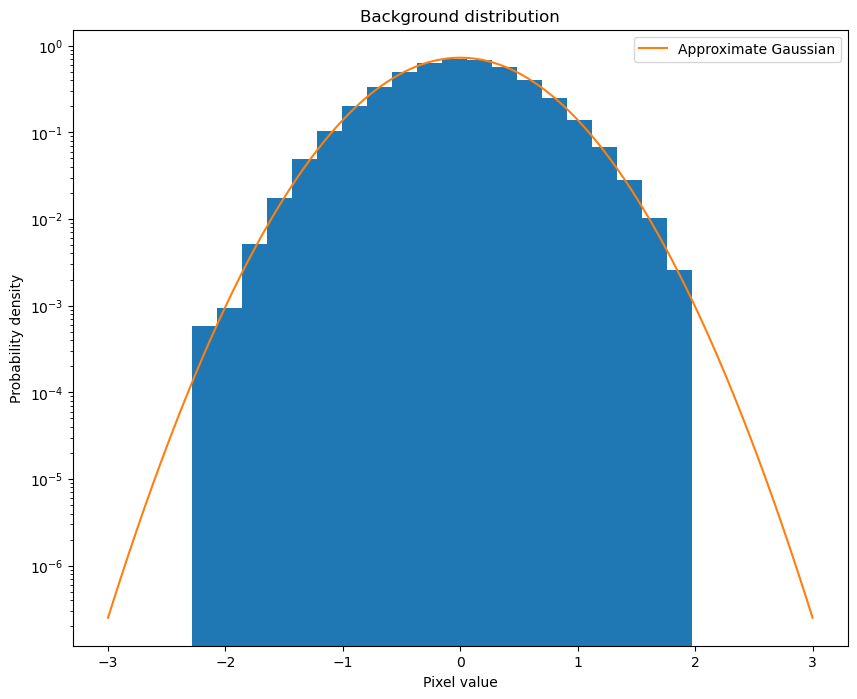

In [139]:
bkg = one_d[0]

# remove higher values to cut out stars
for i in range(len(bkg)):
    if bkg[i] > 2:
        bkg[i] = 0

for j in range(1,10):
    bkg2 = one_d[j]
    for i in range(len(bkg2)):
        if bkg2[i] > 2:
            bkg2[i] = 0
    np.convolve(bkg,bkg2)
x = np.linspace(-3,3, 1000)
plt.hist(bkg, bins=20, density=True)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=0.55), label='Approximate Gaussian')
plt.yscale('log')
plt.title('Background distribution')
plt.ylabel('Probability density')
plt.xlabel('Pixel value')
plt.legend()
plt.show()

#### 3)

Now to find the faintest stars, we will average all of the images without excluding any data. Then we can find the probability of the signals based on the Gaussian distribution.

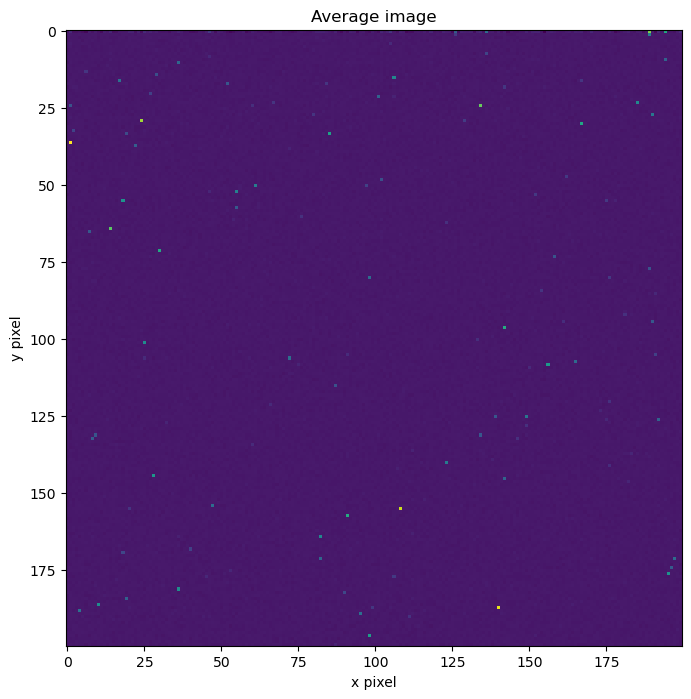

In [103]:
star_sum = stars[:,:,0]

for i in range(1,10):
    star_sum += stars[:,:,i]
star_sum = star_sum / 10
plt.imshow(star_sum)
plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.title('Average image')
plt.show()

To find the dim stars, we will look for all of the pixels brigher than the threshold value, which will be the same as the cutoff point for the background I used above, 2 and less than some value that no longer qualifies as dim, which I will say is 6. Then I'll iterate over the image to pick out all pixels with those values as dim star candidates and place them in a dictionary along with their corresponding significance.

In [133]:
dim_star_candidates = {}
cand_x = []
cand_y = []
dim_stars = {}
dim_star_x = []
dim_star_y = []
for i in range(200):
    for j in range(200):
        val = star_sum[i,j]
        if (val>2) and (val<6):
            p = stats.norm.sf(val, loc=0, scale=0.55)
            sig = stats.norm.ppf(p)
            if sig <= -5:
                dim_stars[f'{i}, {j}'] = abs(sig)
                dim_star_candidates[f'{i}, {j}'] = abs(sig)
                dim_star_x.append(i)
                dim_star_y.append(j)
            else:
                dim_star_candidates[f'{i}, {j}'] = abs(sig)
                cand_x.append(i)
                cand_y.append(j)

In [126]:
print(dim_stars)
print()
print('Percentage of confirmed candidates: ', len(dim_stars)/len(dim_star_candidates))

{'0, 12': 6.1968931366080735, '0, 21': 9.882454640794442, '0, 23': 7.3365919239425805, '0, 29': 5.96764936872729, '0, 36': 10.047053586578414, '0, 45': 7.353285504423346, '0, 47': 6.991074502107978, '0, 49': 6.099663425388778, '0, 60': 5.916551251312997, '0, 69': 5.498019420086325, '0, 81': 9.813864945344813, '0, 82': 10.399965605260224, '0, 83': 10.599498210237773, '0, 84': 6.389586787389842, '0, 87': 10.058756832443782, '0, 92': 8.285469205955515, '0, 93': 6.1770661332065595, '0, 99': 5.229411810931885, '0, 108': 8.918744041868749, '0, 109': 5.224981104819856, '0, 116': 5.84386280973599, '0, 123': 6.652574371715756, '0, 129': 7.050451696332916, '0, 130': 6.555839728651356, '0, 131': 8.64154424894823, '0, 133': 8.56016959764773, '0, 138': 5.411676621996647, '0, 140': 5.903760988499569, '0, 151': 10.437164443408586, '0, 157': 10.590718410410696, '0, 158': 5.554343039262878, '0, 163': 6.157883418951174, '0, 165': 8.961550535234066, '0, 166': 6.511708745949135, '0, 167': 9.93977314091195

From this, we see that if our detection threshold was something like 5 or 6, only around 37% would be confirmed. This might mean I underestimated where to cut out data from the background.

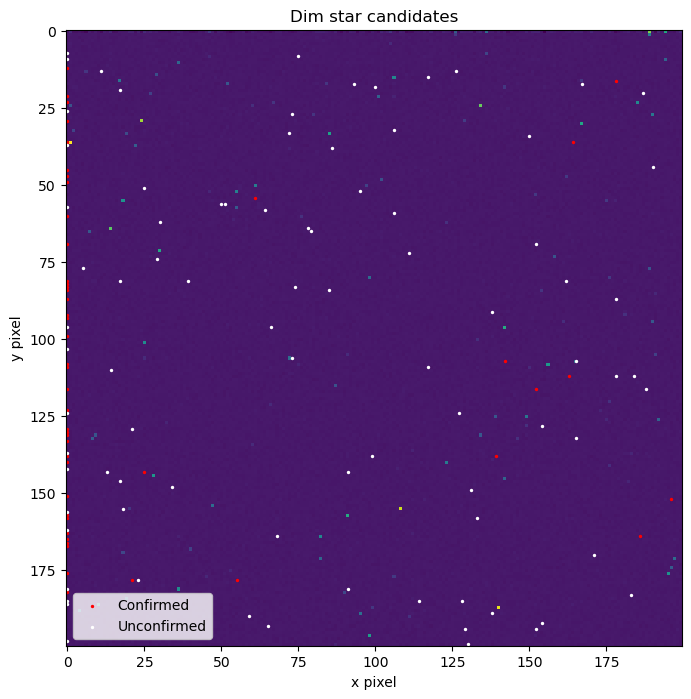

In [136]:
plt.imshow(star_sum)
plt.scatter(dim_star_x, dim_star_y, s=2, c='r', label='Confirmed')
plt.scatter(cand_x, cand_y, s=2, c='w', label='Unconfirmed')
plt.title('Dim star candidates')
plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.legend()
plt.show()

We can see in this plot that there is an odd clustering of candidates on the left edge of the image. This is most likely some kind of instrumental noise that I did not notice while inspecting it before.

#### 4)

In my case, I combined all of the images, since we can assume all of the dim stars will be in the same place in each image. Since the other signal is a transient, where they are looking for a single event that could happen in any pixel in any image, instead of combining all of the images they need to look at each image separately, so each will have its own background distribution. They will also use a trial factor for calculating their probability based on the total number of pixels they are looking at.